# Binary Classification with a DisCoCat model

In this example we will train a **DisCoCat** model to predict whether a sentence is related to food or IT.<br>
<br>Let us start by importing some libraries.

In [1]:
import sys; sys.path.append('../src')
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import Image

### Reading the dataset

The DisCoCat model uses a pregroup grammar to map words types into vector spaces. The meaning of a sentence can be extracted from the tensor product of its vector words, following a set of rules established by the same pregroup grammar.<br>
<br>The dataset used in this exercise is consists of sentences related either to *food* or *IT*. The goal of the trained DisCoCat model is to predict the labels of 30 of these sentences in the test dataset.

In [2]:
from discocat_aux import read_data

train_labels, train_data = read_data('../Datasets/mc_train_data.txt')
val_labels, val_data = read_data('../Datasets/mc_dev_data.txt')
test_labels, test_data = read_data('../Datasets/mc_test_data.txt')

A couple of sentences conforming the training dataset and their labels are:<br>
<br>$${\rm skillful\ man\ prepares\ sauce\ .\qquad food}\rightarrow[1,\ 0]$$
$${\rm skillful\ woman\ debugs\ program\ .\qquad IT}\rightarrow[0,\ 1]$$
<br>The *read_data* function returns the lists **[1, 0]** and **[0, 1]** for the labels **food** and **IT**, respectively.

### Mapping sentences into diagrams

To train the DisCoCat model we build on top of *lambeq* (https://github.com/CQCL/lambeq), a toolkit developed for Quantum Natural Language Processing. The function *BobcatParser* can be used to build diagrams from sentences using different cathegory types to assign vector spaces to word types.<br>
<br>In this example we use the cathegory types for sentence and noun, $S$ and $N$, and the following mapping:<br>
<br><p style='text-align: center;'>*noun* $\rightarrow\ N$
<br>*adjective* $\rightarrow\ N \cdot N^l$
<br>*verb* $\rightarrow\ N^r \cdot S \cdot N^l$<br></p>

In [3]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('S', 'N'), verbose='suppress');
raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

/Users/uvc/miniconda3/envs/qnlp-tut/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


As an example, the diagram for the sentence *'skillful man prepares sauce'* is shown below

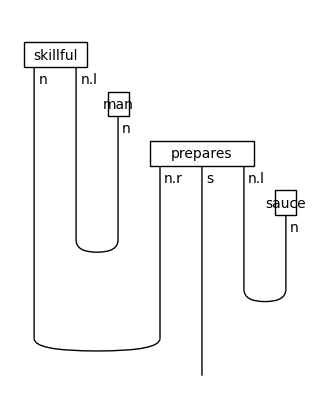

In [4]:
raw_train_diagrams[0].draw(figsize=(3,4))

This sentence is syntactically correct, as it can be reduced to type $S$ following the rules<br>
$$N^l \cdot N = 1 = N \cdot N^r$$
The sentece corresponding to the diagram above has cathegory type
<br><p style='text-align: center;'>
$\quad$ *skillful* $\quad$ *man* $\quad\ $ *prepares* $\quad$ *sauce*<br>
$(N \cdot N^l)\ \cdot\ N\ \cdot\ (N^r \cdot S \cdot N^l)\ \cdot\ N$<br>
$N \cdot (N^l \cdot N) \cdot N^r \cdot S \cdot (N^l \cdot N)$<br>
$N \cdot 1 \cdot N^r \cdot S \cdot 1$<br>
$(N \cdot N^r) \cdot S$<br>
$1 \cdot S$<br>
$S$

Each vertical line in the above diagram represents a vector space. To reduce the complexity of the diagram, we use *lambeq*'s function *remove_cups*

In [5]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
val_diagrams = [remove_cups(diagram) for diagram in raw_val_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

The above diagram takes the following form

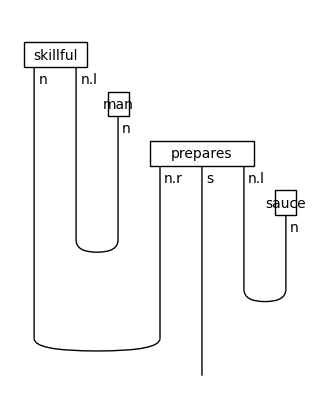

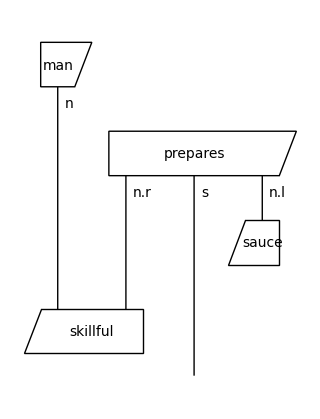

In [6]:
raw_train_diagrams[0].draw(figsize=(3,4))
train_diagrams[0].draw(figsize=(3,4))

### Constructing the quantum circuits

To map a diagram into a quantum circuit, an *n-qubit* space is assigned to each cathegory type, and an Instantaneous Quantum Polynomial (IQP) circuit is constructed using *lambeq*'s *IQPAnsatz* function.<br>
<br>In this tutorial, we chosse one-qubit spaces for both $S$ and $N$<br>
<br>The IQP circuit is constructed as follows:
- Vectors representing single-qubit words (nouns) are defined by the rotations $R_xR_zR_x$, follow by a Hadamard gate.
- Vectors representing multi-qubit words (adjectives and verbs) are defined by a layer of Hadamard gates on the qubits representing the word, followed by two layers of $CRZ$ gates between every pair of neighboring qubits. Each of these layers is followed by a layer of Hadamard gates.</p>

The angles in the rotational gates of the IQP cirucuit are the trainable parameters of the model.

In [7]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                    n_layers=2, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
val_circuits = [ansatz(diagram) for diagram in val_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

The quantum circuit corresponding to the sentence *'skillful man prepares sauce'* is shown below.

	 q0		     q1			 q2		     q3


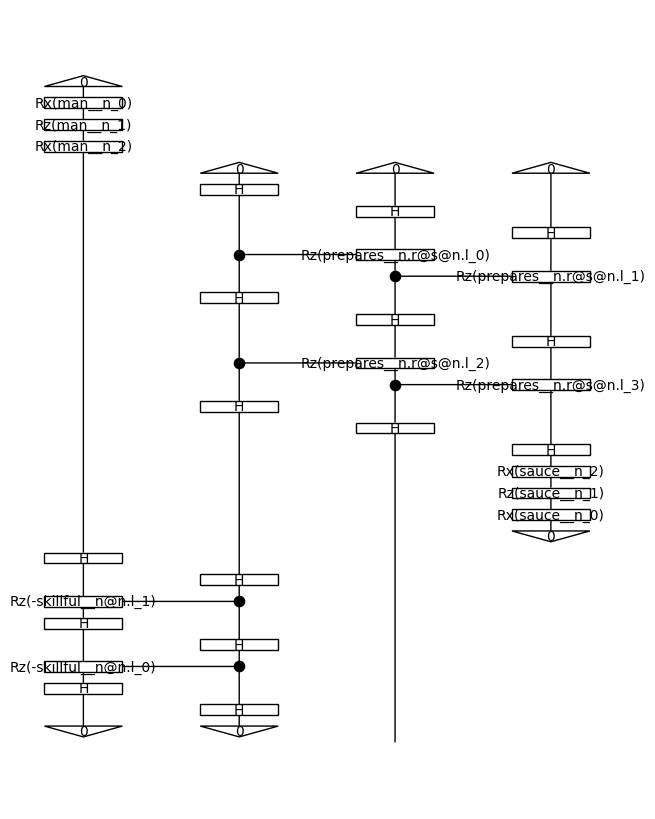

In [33]:
from pytket.circuit.display import render_circuit_jupyter

print('\t q0\t\t     q1\t\t\t q2\t\t     q3')
train_circuits[0].draw(figsize=(6,8))
render_circuit_jupyter(ansatz(train_diagrams[0]).to_tk())

The meaning of the sentence can be extracted from the probabilities for qubit $2$ to be in state $\ket{0}$ or $\ket{1}$ when the rest of the qubits are in state $\ket{0}$

### Defining the model

Once the sentences have been mapped into quantum circuits, we define the loss function and optimizer that will be used to train the model:
- The chosen loss function is the Binary Cross Entropy.
- The model's accuracy on the test set will be used as a metric of its performance.
- The parameters of the model are updated using the Simultaneous Perturbation Stochastic Approximation (SPSA) optimizer, a gradient descent method.

In [8]:
from lambeq import BinaryCrossEntropyLoss

bce = lambda y_hat, y: -np.sum(y * np.log(y_hat) + (1-y) * np.log(1-y_hat)) / len(y)
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

The model used in this tutorial, *DisCoCatClassifier*, builds on top of *lambeq*'s *TketModel*. Our model constructs the quantum circuits using *PennyLane* and simulates their execution using the *default.qubit* backend.

In [9]:
from discocat_models import DisCoCatClassifier
from pytket.extensions.qiskit import AerBackend

all_circuits = train_circuits + val_circuits + test_circuits

backend = AerBackend()
backend_config = {'backend': backend,
                  'compilation': backend.default_compilation_pass(2),
                  'shots': 8192}

model = DisCoCatClassifier.from_diagrams(all_circuits, backend_config=backend_config)

In [15]:
from lambeq import QuantumTrainer, SPSAOptimizer

BATCH_SIZE = 10
EPOCHS = 80
SEED = 8

trainer = QuantumTrainer(model,
                         loss_function=bce,
                         epochs=EPOCHS,
                         optimizer=SPSAOptimizer,
                         optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
                         evaluate_functions={'acc': acc},
                         evaluate_on_train=True,
                         verbose = 'text',
                         seed=SEED)

### Model training

The training can be easily parallelized by simulating subsets of the quantum circuits on different MPI processes (see *discocat_aux.py*).

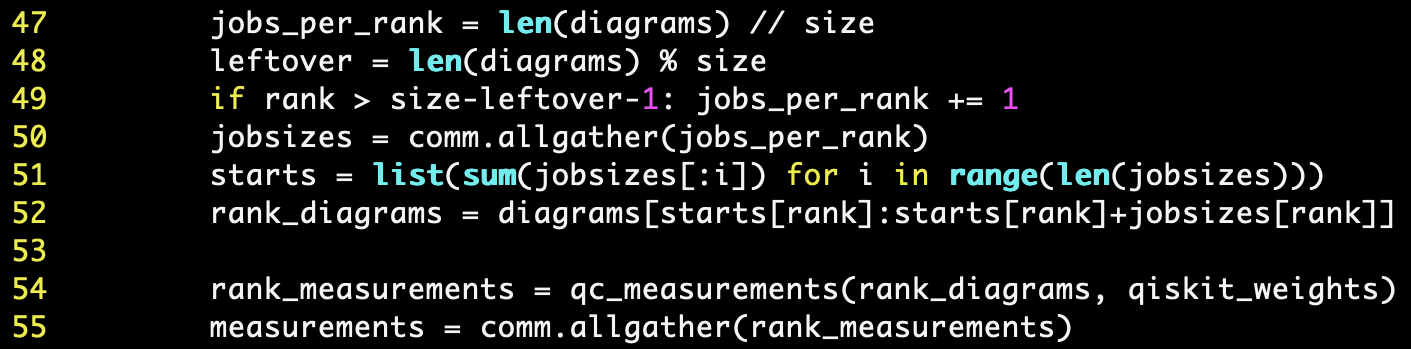

In [16]:
Image(filename='../Figures/paralleldiscocat.png', width=700)

In [17]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

In [ ]:
trainer.fit(train_dataset, val_dataset, log_interval=10)

Test accuracy: 0.5666666666666667


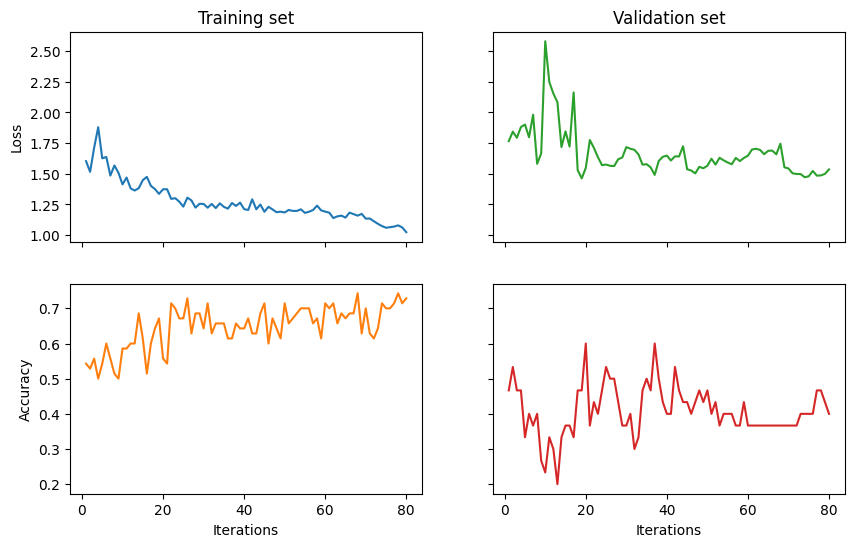

In [14]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Validation set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)